In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

In [3]:
plt.rcParams["figure.figsize"] = (12,12)

import sys
import glob

sys.path.append('../')

from bbox_utils.bbox import generate_default_boxes, generate_default_boxes, rotateRectangle
from src.config import *

from bbox_utils.numbaClipping import getIOU, getIOUOverallDefaultBox, shoelaceFormula

In [4]:
# Blue color in BGR
color = (255, 0, 0)
 
# Line thickness of 2 px
thickness = 1

In [5]:
prior_boxes, prior_boxes_coco, prior_box_area = generate_default_boxes(feature_map_shapes, 6, aspect_ratios, angles)

prior_boxes = np.array(prior_boxes, dtype=np.float64) * 300

prior_boxes_coco = np.array(prior_boxes_coco, dtype=np.float64)

prior_boxes_coco[:, :4] = prior_boxes_coco[:, :4] * 300

In [6]:
print(len(prior_boxes_coco))
len(prior_boxes) == len(prior_boxes_coco)

31044


True

In [7]:
prior_boxes, prior_boxes_coco, prior_box_area = generate_default_boxes(feature_map_shapes, 6, aspect_ratios, angles)

prior_boxes = np.array(prior_boxes, dtype=np.float32)

prior_boxes_coco = np.array(prior_boxes_coco, dtype=np.float32)

list_IDs = glob.glob('/Users/usmanr/workspace/rotatedBoxes_Inputs/input/train/*.txt')

list_IDs = [l.split('/')[-1].replace('.txt', '') for l in list_IDs]

In [34]:
from data_pipeline.dataGenerator import DataGenerator

In [35]:
label_path = '/Users/usmanr/workspace/rotatedBoxes_Inputs/input/train/'
image_path = '/Users/usmanr/fiftyone/coco-2014/train/data/'

In [38]:
dg = DataGenerator(list_IDs, 
                   label_path,
                   image_path, 
                   prior_boxes,
                   prior_boxes_coco,
                   prior_box_area,
                   batch_size=32,
                   n_classes=4,
                  image_extension='.jpg')

In [39]:
%%time

for d in dg:
    holdout = d
    break

CPU times: user 21.8 s, sys: 1.11 s, total: 22.9 s
Wall time: 2.14 s


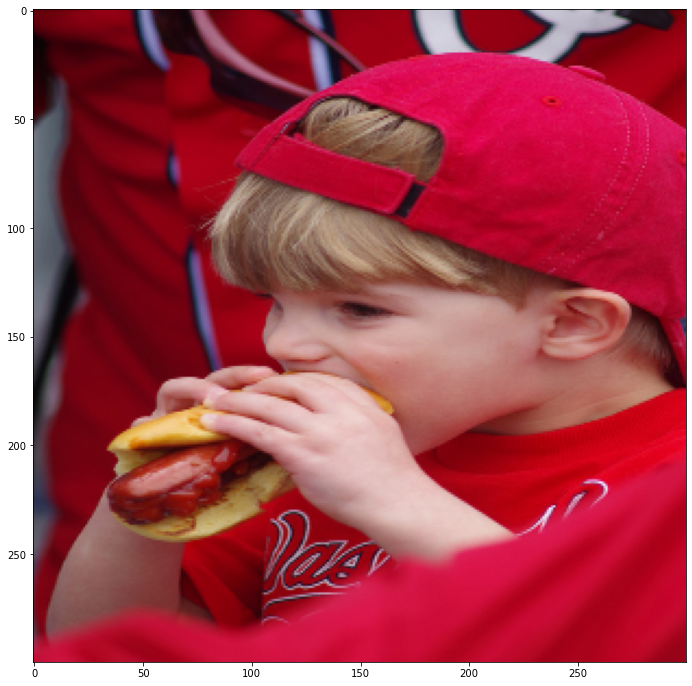

In [40]:
plt.imshow(holdout[0][1])

In [41]:
holdout[1][1][8]

<tf.Tensor: shape=(31044, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [42]:
for i, label in enumerate(holdout[1][1][12]):
    l = label.numpy()
    if sum(l[1:]) > 0:
        print(i)

2074
2089
2104
2644
2659
27173
27174
27175
27192
27193
27194
27195
27211
27212
27553
27554
27574
29907
29909
29910
29912
29916
30085
30089
30096
30097
30098
30099
30100
30101
30102
30103
30104
30105
30106
30107
30108
30553
30555
30556
30557
30558
30560
30571
30572
30573
30574
30575
30576
30577
30578
30579
30580
30582
30583
30758
31011


In [43]:
gt_box = np.array([[0.971875,   0.38497654, 0.971875,   0.37089202, 0.98125,    0.37089202,
 0.98125,    0.38497654]]) * 300

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


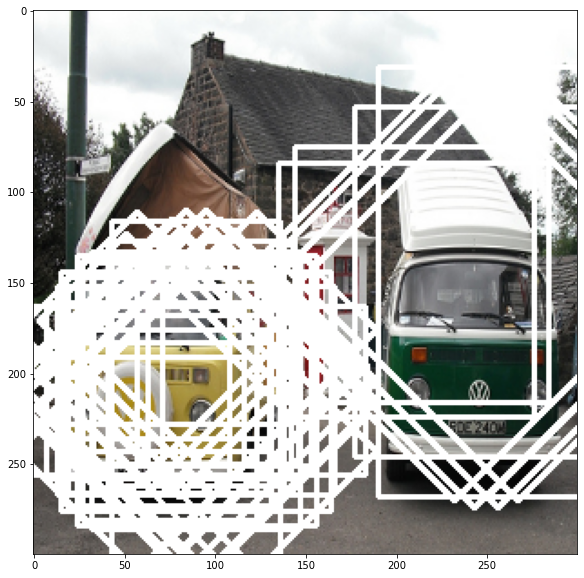

In [45]:
image_number = 0
image_copy = holdout[0][image_number].copy()

for i, label in enumerate(holdout[1][1][image_number]):
    l = label.numpy()
    if sum(l[1:]) > 0:

        corners = np.array(prior_boxes[i]) * 300

        corners = corners.astype(np.int32)

        corners = corners.reshape(4, 2)

        corners = corners.reshape((-1, 1, 2))

        image = cv2.polylines(image_copy, [corners],
                              True, (255, 10, 10), 2)

# corners = gt_box.astype(np.int32)

# corners = corners.reshape((-1, 1, 2))

# image = cv2.polylines(image_copy, [corners],
#                       True, (255, 0, 0), 2)
        
plt.figure(figsize=(10,10))

plt.imshow(image_copy)

In [ ]:
print(prior_boxes[14252] * 300)
prior_boxes_coco[14252] * 300

In [ ]:
gt_boxes = np.array([ [0.971875,   0.38497654, 0.971875,   0.37089202, 0.98125,    0.37089202,
 0.98125,    0.38497654] ])
gt_boxes_coco = np.array([ [0.9765625,  0.37793428, 0.009375,   0.01408451, 1.5707964 ] ])

# gt_box = np.array([[0.7106131, 0.15125829, 0.8009922, 0.09430233, 0.8902517, 0.41249308, 0.7998726,  0.46944904]])
# gt_boxes_coco = np.array([ 0.8004324, 0.2818757, 0.0980429, 0.34517202, -0.3980142 ])

In [ ]:
IOU_map = np.zeros((1, len(prior_boxes), len(gt_boxes)))
gt_boxes = np.array(gt_boxes, np.float32)
gt_boxes_coco = np.array(gt_boxes_coco, np.float32)

for i in range(len(gt_boxes)):
    print('gt: ', gt_boxes[i])
    print('gt_box: ', gt_boxes_coco[i])
    IOU_map[0, :, i] = getIOUOverallDefaultBox( prior_boxes, gt_boxes[i], prior_boxes_coco, gt_boxes_coco[i], prior_box_area )

In [ ]:
np.min(IOU_map)

In [ ]:
# select the box with the highest IOU
highest_overlap_idx = tf.math.argmax(IOU_map, axis = 1)

In [ ]:
highest_overlap_idx

In [ ]:
gt_boxes = np.array( [0.971875,   0.38497654, 0.971875,   0.37089202, 0.98125,    0.37089202,
 0.98125,    0.38497654] )
gt_boxes_coco = np.array( [0.9765625,  0.37793428, 0.009375,   0.01408451, 1.5707964 ] )

In [ ]:
c_x = gt_boxes_coco[0]
c_y = gt_boxes_coco[1]
rot_angle = gt_boxes_coco[4]

if rot_angle >= -0.7853981633974483 and rot_angle <= 0.7853981633974483: # 45 deg in rad
    width = gt_boxes_coco[2]
    height = gt_boxes_coco[3]
else:
    width = gt_boxes_coco[3]
    height = gt_boxes_coco[2]

left_limit = c_x - 1.5 * width
right_limit = c_x + 1.5 * width
# c_x_in_bound = np.where(
#     (prior_boxes_coco[:,0 ] >= left_limit) & (prior_boxes_coco[:,0 ] <= right_limit), True, False)

c_x_in_bound = np.where(
    (prior_boxes_coco[:,0 ] >= 0), True, False)

up_limit = c_y - 1.5 * height
down_limit = c_y + 1.5 * height
# c_y_in_bound = np.where(
#     (prior_boxes_coco[:,1 ] >= up_limit) & (prior_boxes_coco[:,1 ] <= down_limit), True, False)

c_y_in_bound = np.where(
    (prior_boxes_coco[:,1 ] >= 0), True, False)

c_in_bound = np.logical_and(c_x_in_bound, c_y_in_bound)

gt_box = gt_box.reshape(4, 2)
gt_area = shoelaceFormula(gt_box)

# if gt_area < 0.006399999999999998:
#     area_bound = np.where( (prior_box_area <= 10 * gt_area), True, False)
# else:
#     area_bound = np.where( (prior_box_area >= 0.4 * gt_area) & (prior_box_area <= 2.5 * gt_area), True, False)
area_bound = np.where( (prior_box_area >= 0), True, False)

in_bound = np.logical_and(c_in_bound, area_bound)

idx = np.argwhere(in_bound)

iou = np.zeros(len(prior_boxes), dtype = np.float64)

for i in range(len(idx)):
    iou[idx[i][0]] = getIOU(prior_boxes[idx[i][0]], gt_box, gt_area)

In [ ]:
rot_angle * 180 / np.pi

In [ ]:
np.sum(iou)

In [ ]:
getIOU(prior_boxes[0], gt_box, gt_area)

In [ ]:
prior_boxes[0], gt_box

In [ ]:
getIOU(prior_boxes[31042], gt_box, gt_area)

In [ ]:
default_box = prior_boxes[31042].reshape(4, 2)
shoelaceFormula(default_box)

In [ ]:
gt_box = np.array([0., 0.4, 0., 0.35625, 0.05882353, 0.35625, 0.05882353, 0.4])

gt_box = gt_box.reshape(4, 2)
gt_area = shoelaceFormula(gt_box)

In [ ]:
getIOU(prior_boxes[0], gt_box, gt_area)

In [ ]:
np.zeros(50, dtype = np.float64)